IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*

# TD-TME06: méthodes d'ensembles

L'objectif de ce TP est d'implémenter des méthodes d'ensembles et de les évaluer. Dans un premier temps, on se focalisera sur l'algorithme de bagging appliqué aux arbres de décision, puis on passera au random forests.

Comme précédemment, on ne considére que le cas où les attributs sont tous numériques.

<font size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Kadoch_Daoud & Lefevre_Sebastien

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-06</tt> et rajouter à la suite de <tt>tme-06</tt> les noms des membres du binômes séparés par un tiret.

Charger la librairie <code>iads</code> pour avoir accès aux fonctions déjà écrites.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

Pour tester les fonctions à implémenter dans cette séance, on utilise la base d'exemples suivante :

In [2]:
# Base d'exemples pour tester les fonctions:
set_exemples = ls.LabeledSet(2)
set_exemples.addExample([2.10492662303,1.10648470933],1)
set_exemples.addExample([0.297525816499,-0.662504551625],1)
set_exemples.addExample([1.6694258992,0.313687975072],1)
set_exemples.addExample([1.20583098523,3.50817309097],1)
set_exemples.addExample([1.13739407316,1.96688273992],1)
set_exemples.addExample([2.32319808376,0.536577798714],1)
set_exemples.addExample([-0.953004346997,0.596926923927],1)
set_exemples.addExample([1.00574784804,-0.0959606771199],1)
set_exemples.addExample([0.747509778063,0.429544908608],1)
set_exemples.addExample([1.39048336283,0.442578873406],1)
set_exemples.addExample([0.0470799329584,-1.97596265858],-1)
set_exemples.addExample([-0.673998013071,0.0693931940855],-1)
set_exemples.addExample([-0.84587451642,0.761766191612],-1)
set_exemples.addExample([-1.39596839858,-0.943807082082],-1)
set_exemples.addExample([0.319301767707,0.566169775123],-1)
set_exemples.addExample([1.43459714786,0.935712030926],-1)
set_exemples.addExample([-1.69323475458,-1.89563184035],-1)
set_exemples.addExample([0.81167008598,-1.17927660655],-1)
set_exemples.addExample([-1.03264043689,-1.08118488864],-1)
set_exemples.addExample([0.609517439986,-2.88593327349],-1)

In [3]:
def newSet(cov, nb_points):
    pourcentage = np.random.uniform(0,1)
    nb1 = int(nb_points*(pourcentage))
    nb2 = int(nb_points*(1-pourcentage))
    """ 
        rend un LabeledSet 2D généré aléatoirement.
        Arguments:
        - positive_center (vecteur taille 2): centre de la gaussienne des points positifs
        - positive_sigma (matrice 2*2): variance de la gaussienne des points positifs
        - negative_center (vecteur taille 2): centre de la gaussienne des points négative
        - negative_sigma (matrice 2*2): variance de la gaussienne des points négative
        - nb_points (int):  nombre de points de chaque classe à générer
    """
    pointPos = np.random.multivariate_normal(np.array([1,1]), np.array([[cov,0],[0,cov]]), nb1)
    pointNeg = np.random.multivariate_normal(np.array([-1,-1]), np.array([[cov,0],[0,cov]]), nb2)
    dataSet  = ls.LabeledSet(2)
    for i in range (nb1):
        dataSet.addExample(pointPos[i],1)
    for i in range (nb2):
        dataSet.addExample(pointNeg[i],-1)
    return dataSet

## Etape 1: retours sur la séance 5


<font color="RED" size="+1">**[Q]**</font> Modifier la fonction <code>shannon()</code> afin qu'elle puisse s'appliquer sur une liste vide ou sur une liste à un seul élément: dans ce cas-là, la fonction rend $0.0$.

In [4]:
import math

def shannon(distr_p):    
    if len(distr_p) <= 1 :
        return 0.0
    
    entropie = 0
    k = len(distr_p)
    for i in range(len(distr_p)):
        pi = distr_p[i]
        if pi != 0 :
            entropie += pi*math.log(pi,k)         
    return entropie*-1


In [5]:
# Exemples d'utilisation:
print("P=[]  : ", shannon([]))
print("P=[1] : ", shannon([1]))

P=[]  :  0.0
P=[1] :  0.0


Recopier les fonctions suivantes à partir de votre notebook du TD-TME05.
- classe_majoritaire(LSet)
- entropie(LSet)
- discretise(LSet, col)
- divise(LSet,att,seuil)
- construit_AD(LSet,epsilon)

ainsi que les classes:
- class ArbreBinaire
- class ArbreDecision

Remplissez la boite suivante en recopiant toutes ces fonctions et classes du TD_TME05.

In [6]:
import graphviz as gv
# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz


class ArbreBinaire:
    def __init__(self):
        self.attribut = None   # numéro de l'attribut
        self.seuil = None
        self.inferieur = None # ArbreBinaire Gauche (valeurs <= au seuil)
        self.superieur = None # ArbreBinaire Gauche (valeurs > au seuil)
        self.classe = None # Classe si c'est une feuille: -1 ou +1
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille """
        return self.seuil == None
    
    def ajoute_fils(self,ABinf,ABsup,att,seuil):
        """ ABinf, ABsup: 2 arbres binaires
            att: numéro d'attribut
            seuil: valeur de seuil
        """
        self.attribut = att
        self.seuil = seuil
        self.inferieur = ABinf
        self.superieur = ABsup
    
    def ajoute_feuille(self,classe):
        """ classe: -1 ou + 1
        """
        self.classe = classe
        
    def classifie(self,exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple: +1 ou -1
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] <= self.seuil:
            return self.inferieur.classifie(exemple)
        return self.superieur.classifie(exemple)
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir
            l'afficher
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.attribut))
            self.inferieur.to_graph(g,prefixe+"g")
            self.superieur.to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))
        
        return g

In [7]:
class ArbreDecision(cl.Classifier):
    # Constructeur
    def __init__(self,epsilon):
        # valeur seuil d'entropie pour arrêter la construction
        self.epsilon= epsilon
        self.racine = None
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        self.racine = construit_ad(set,self.epsilon)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

In [8]:
def classe_majoritaire(labeled):
    nbPos = 0
    nbNeg = 0
    for i in range(labeled.size()):
        if labeled.getY(i) == 1:
            nbPos += 1
        else:
            nbNeg += 1
    
    if nbPos >= nbNeg :
        return 1
    return -1
    
def entropie(labeled):
    
    nb_pos = 0
    nb_neg = 0
    for i in range(labeled.size()):
        if labeled.getY(i) == 1:
            nb_pos += 1
        else:
            nb_neg += 1
   
    taille = labeled.size()
    proba_pos = nb_pos/taille*1.0
    proba_neg = nb_neg/taille*1.0
    
    return shannon([proba_neg,proba_pos])

def discretise(LSet, col):
    """ LabelledSet * int -> tuple[float, float]
        Hypothèse: LSet.size() >= 2
        col est le numéro de colonne sur X à discrétiser
        rend la valeur de coupure qui minimise l'entropie ainsi que son entropie.
    """
    # initialisation:
    min_entropie = 1.1  # on met à une valeur max car on veut minimiser
    min_seuil = 0.0     
    # trie des valeurs:
    ind= np.argsort(LSet.x,axis=0)
    
    # calcul des distributions des classes pour E1 et E2:
    inf_plus  = 0               # nombre de +1 dans E1
    inf_moins = 0               # nombre de -1 dans E1
    sup_plus  = 0               # nombre de +1 dans E2
    sup_moins = 0               # nombre de -1 dans E2       
    # remarque: au départ on considère que E1 est vide et donc E2 correspond à E. 
    # Ainsi inf_plus et inf_moins valent 0. Il reste à calculer sup_plus et sup_moins 
    # dans E.
    for j in range(0,LSet.size()):
        if (LSet.getY(j) == -1):
            sup_moins += 1
        else:
            sup_plus += 1
    nb_total = (sup_plus + sup_moins) # nombre d'exemples total dans E
    
    # parcours pour trouver le meilleur seuil:
    for i in range(len(LSet.x)-1):
        v_ind_i = ind[i]   # vecteur d'indices
        courant = LSet.getX(v_ind_i[col])[col]
        lookahead = LSet.getX(ind[i+1][col])[col]
        val_seuil = (courant + lookahead) / 2.0;
        # M-A-J de la distrib. des classes:
        # pour réduire les traitements: on retire un exemple de E2 et on le place
        # dans E1, c'est ainsi que l'on déplace donc le seuil de coupure.
        if LSet.getY(ind[i][col])[0] == -1:
            inf_moins += 1
            sup_moins -= 1
        else:
            inf_plus += 1
            sup_plus -= 1
        # calcul de la distribution des classes de chaque côté du seuil:
        nb_inf = (inf_moins + inf_plus)*1.0     # rem: on en fait un float pour éviter
        nb_sup = (sup_moins + sup_plus)*1.0     # que ce soit une division entière.
        # calcul de l'entropie de la coupure
        val_entropie_inf = shannon([inf_moins / nb_inf, inf_plus  / nb_inf])
        val_entropie_sup = shannon([sup_moins / nb_sup, sup_plus  / nb_sup])
        val_entropie = (nb_inf / nb_total) * val_entropie_inf \
                       + (nb_sup / nb_total) * val_entropie_sup
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (min_entropie > val_entropie):
            min_entropie = val_entropie
            min_seuil = val_seuil
    return (min_seuil, min_entropie)


def divise(LSet,att,seuil):
    """ LSet: LabeledSet
        att : numéro d'attribut
        seuil : valeur de seuil
        rend le tuple contenant les 2 sous-LabeledSet obtenus par la
        division de LSet selon le seuil sur l'attribut att
    """
    #Etape 1: ordonner de façon croissante les valeurs de  AXAX ;
    label_inf = ls.LabeledSet(LSet.getInputDimension())
    label_sup = ls.LabeledSet(LSet.getInputDimension())

    
    for i in range(0,LSet.size()):
        if (LSet.getX(i)[att] < seuil):
            label_inf.addExample(LSet.getX(i), LSet.getY(i))
        else : label_sup.addExample(LSet.getX(i), LSet.getY(i))
            
    return label_inf,label_sup

def construit_AD(LSet,epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    arbre = ArbreBinaire()
    
    entro = entropie(LSet)
    if entro <= epsilon :
        #construction
        classe = classe_majoritaire(LSet)
        arbre.ajoute_feuille(classe)
        
    else : 
        l_seuil = []
        l_entropie = []
        for attr in range(LSet.input_dimension):
            seuil, entro = discretise(LSet, attr)
            l_seuil.append(seuil), l_entropie.append(entro)
    
        att_min = np.argmin(np.array(l_entropie))
        seuil_min = l_seuil[att_min]
        inf, sup = divise(LSet,att_min,seuil_min)
        
        ab_inf = construit_AD(inf,epsilon)

        ab_sup = construit_AD(sup,epsilon)
        
        arbre.ajoute_fils(ab_inf,ab_sup,att_min,seuil_min)
    
    return arbre


<font color="RED" size="+1">**[Q]**</font> Modifier la fonction <code>construit_ad</code> afin d'utiliser le gain d'information comme critère d'arrêt. 

L'algorithme est modifié ainsi:

Pour construire un arbre de décision, il faut réaliser les étapes suivantes:
- si l'entropie de Shannon de l'ensemble courant est inférieure à epsilon (réel positif fixé et qui est un paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire;
- sinon, pour chaque attribut, calculer le seuil de discrétisation et l'entropie de Shannon correspondante
    - choisir l'attribut qui donne une valeur d'entropie minimale
    - regarder le gain d'information apporté par le test sur les valeurs de cet attribut
        - si ce gain est inférieur à epsilon alors construire une feuille avec l'ensemble
        - sinon l'attribut choisi sert à constituer un noeud de l'arbre de décision, les arcs issus de ce noeud sont labeller par un test (inférieur ou égal ou supérieur) par rapport au seuil trouvé
    
On rappelle (cf. cours) que le gain d'information vaut:

$$I_s(A_j,Y) = D(Y) - Q_Y(A_j)$$

avec $D(Y)$, l'entropie de Shannon de l'ensemble courant, et $Q_Y(A_j)$ l'entropie de de la classe pour la coupure par le seuil trouvé sur l'attribut $A_j$).



In [9]:
def construit_ad(LSet,epsilon):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
    arbre = ArbreBinaire()
    
    entro = entropie(LSet)
    if entro <= epsilon :
        #construction
        classe = classe_majoritaire(LSet)
        arbre.ajoute_feuille(classe)
        
    else : 
        l_seuil = []
        l_entropie = []
        for attr in range(LSet.input_dimension):
            seuil, entro = discretise(LSet, attr)
            l_seuil.append(seuil), l_entropie.append(entro)
    
        att_min = np.argmin(np.array(l_entropie))
        seuil_min = l_seuil[att_min]
        
        if (entro - min(l_entropie)>=epsilon):
            inf, sup = divise(LSet,att_min,seuil_min)
            
            ab_inf = construit_ad(inf,epsilon)
            ab_sup = construit_ad(sup,epsilon)

            arbre.ajoute_fils(ab_inf,ab_sup,att_min,seuil_min)
        else:
            classe = classe_majoritaire(LSet)
            arbre.ajoute_feuille(classe)
            
    return arbre

<font color="BLUE" size="+1">*** [Commentaire] ***</font> 

Afin d'eviter de tomber dans une boucle infinie ou creer des sous branches apportant que d'information pour la decision, on verifie que le gain d'information obtenue par la difference de l'entropie courante et celle trouvée via l'attribut la minimisant. si cette difference est grande alors l'attribut permet de bien séparer nos sous ensemble sinon les sous ensemble ne peuvent pas plus etre separer il faut alors créer une feuille.

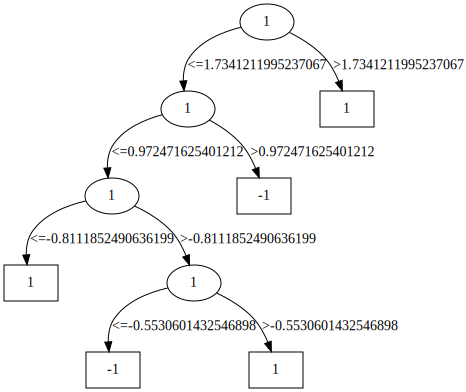

In [10]:
#test de l'affichage 
the_set = newSet(10,40)
abin = construit_ad(the_set,0.0)
print()
gtree = gv.Digraph(format='png')
abin.to_graph(gtree)

## Etape 2: Bagging d'arbres de décision

### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$. Cet échantillon sert ensuite à construire un classifieur.

Dans l'algorithme du bagging, ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


#### Tirages aléatoires en Python

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [11]:
import random
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
EchL = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon: ",EchL)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Echantillon:  [10, 5, 8, 4, 3, 1]


La fonction <code>choice()</code> permet de choisir aléatoirement un élément:

In [12]:
L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Element choisi:  1


<font color="RED" size="+1">**[Q]**</font> Ecrire une fonction <code>tirage()</code> qui étant donné un vecteur d'entiers $VX$ qui représente l'ensemble des indices des exemples d'une base d'apprentissage $X$, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans $VX$. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [13]:
def tirage(vect, m, r):
    """
    vect -> représente l'ensemble des indices des exemples
    m -> indique combien de fois le processus sera répété
    r -> true alors le tirage est avec remise et sans remise sinon
    """

    liste = []
    if r : # avec remise
        for i in range(m):
            elt = random.choice(vect)
            liste.append(elt)
            
        return liste

    else: # sans remise
        return random.sample(vect,m)

Exemples :

In [14]:
L= [i for i in range(0,20)]    # construction de la liste des entiers de 0 à 100
tirage(L,8,True)               # tirage avec remise

[8, 15, 15, 7, 14, 3, 6, 2]

In [15]:
tirage(L,8,False)               # tirage sans remise

[18, 17, 5, 10, 15, 6, 1, 0]

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $X$, un nombre entier $m$, et un booléen rend un échantillon de $X$ de taille $m$ sous la forme d'un <code>LabeledSet</code>. L'échantillon est obtenu par un tirage avec remise si le booléen est True, sinon, il est obtenu sans remise.

In [16]:
def echantillonLS(data, m, r):
    vect = []

    for i in range(data.size()):
        vect.append(i)

    liste = tirage(vect, m, r)

    label = ls.LabeledSet(data.getInputDimension())
    
    for i in range(len(liste)):
        ind = liste[i]
        
        x = data.getX(ind)
        y = data.getY(ind)
        label.addExample(x,y)

    return label

<font color="RED" size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision. Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants : 
    - le nombre $B$ d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - un booléen qui précise si un échantillon est tiré avec ou sans remise
    - et la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (<code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1.

In [17]:
class ClassifierBaggingTree(cl.Classifier):
    
    def __init__(self, nbB, percent, epsilon, remise):
        self.list_ad = []
        self.nbB = nbB
        self.percent = percent
        self.remise = remise
        self.epsilon = epsilon
        
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        sumVote = 0

        for ad in self.list_ad:
            res = ad.predict(x)
            sumVote+=res
        if sumVote < 0 :
            return -1
        else: return 1
            
    def train(self, data_train):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        for i in range(self.nbB):
            m =int(data_train.size()*self.percent)

            ls = echantillonLS(data_train,int(data_train.size()*self.percent), self.remise)
            ad = ArbreDecision(self.epsilon)
            ad.train(ls)
            self.list_ad.append(ad)    
            
    def accuracy(self, data_test):
        """ Permet de calculer la qualité du système 
        """
        cpt = 0
        for i in range(data_test.size()):
            res = self.predict(data_test.getX(i))
            if (res * data_test.getY(i)) > 0 : 
               cpt += 1 
            
        return cpt/data_test.size()*1.0

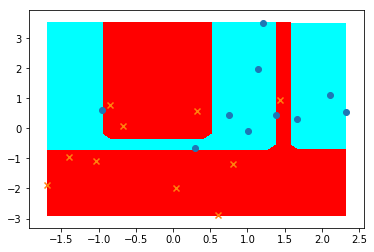

In [18]:
adautre=ArbreDecision(0.0)          
adautre.train(set_exemples)            
ut.plot_frontiere(set_exemples,adautre,20)
ut.plot2DSet(set_exemples) 
adautre.plot()
plt.show()

#adautre.predict([0.29752582, -0.66250455])

exemple: 0  vraie classe =  [1] - classe trouvee =  1
exemple: 1  vraie classe =  [1] - classe trouvee =  1
exemple: 2  vraie classe =  [1] - classe trouvee =  1
exemple: 3  vraie classe =  [1] - classe trouvee =  1
exemple: 4  vraie classe =  [1] - classe trouvee =  1
exemple: 5  vraie classe =  [1] - classe trouvee =  1
exemple: 6  vraie classe =  [1] - classe trouvee =  1
exemple: 7  vraie classe =  [1] - classe trouvee =  1
exemple: 8  vraie classe =  [1] - classe trouvee =  1
exemple: 9  vraie classe =  [1] - classe trouvee =  1
exemple: 10  vraie classe =  [-1] - classe trouvee =  -1
exemple: 11  vraie classe =  [-1] - classe trouvee =  -1
exemple: 12  vraie classe =  [-1] - classe trouvee =  -1
exemple: 13  vraie classe =  [-1] - classe trouvee =  -1
exemple: 14  vraie classe =  [-1] - classe trouvee =  -1
exemple: 15  vraie classe =  [-1] - classe trouvee =  -1
exemple: 16  vraie classe =  [-1] - classe trouvee =  -1
exemple: 17  vraie classe =  [-1] - classe trouvee =  -1
exem

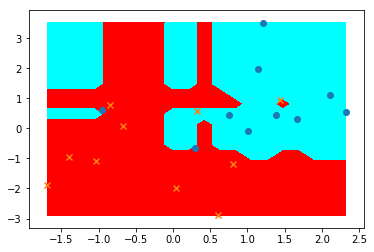

In [19]:
foret = ClassifierBaggingTree(10,1,0.0,True)
foret.train(set_exemples)
for i in range(set_exemples.size()):
    print("exemple:",i," vraie classe = ", set_exemples.getY(i), "- classe trouvee = ", foret.predict(set_exemples.getX(i)))
    
ut.plot_frontiere(set_exemples,foret,20)
ut.plot2DSet(set_exemples) 

print("\naccuracy totale:",foret.accuracy(set_exemples))

### Expérimentations

<font color="RED" size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer une base d'apprentissage $X$ contenant au moins 1000 exemples ;
- réaliser un échantillon de cette base contenant 50 exemples de chaque classe. Soit $E$ cet échantillon, et soit $F$ l'ensemble des exemples de $X$ qui ne sont pas dans $E$ ;
- réaliser un apprentissage par bagging sur $F$ et évaluer le taux de prédiction du modèle obtenu sur $E$ ;
- construire la courbe donnant le taux de prédiction obtenu en augmentant la taille de la forêt d'arbres de 1 à 20 arbres. 

In [20]:
def newSet_eq(cov, nb_points):
    pourcentage = 0.5
    nb1 = int(nb_points*(pourcentage))
    nb2 = int(nb_points*(1-pourcentage))

    pointPos = np.random.multivariate_normal(np.array([1,1]), np.array([[cov,0],[0,cov]]), nb1)
    pointNeg = np.random.multivariate_normal(np.array([-1,-1]), np.array([[cov,0],[0,cov]]), nb2)
    dataSet  = ls.LabeledSet(2)
    for i in range (nb1):
        dataSet.addExample(pointPos[i],1)
    for i in range (nb2):
        dataSet.addExample(pointNeg[i],-1)
    return dataSet

In [21]:
def diff(l2,l1):
    """rend l2 - l1"""
    
    label = ls.LabeledSet(l2.getInputDimension())
    
    for i in range(l2.size()):
        if (l2.getX(i) not in l1.getX_vector()):
            label.addExample(l2.getX(i),l2.getY(i))
    return label

In [22]:
def concat(E1,E2):
    label = ls.LabeledSet(E2.getInputDimension())
    for i in range(E1.size()):
        label.addExample(E1.getX(i),E1.getY(i))
    
    for i in range(E2.size()):
        label.addExample(E2.getX(i),E2.getY(i))
    return label

In [23]:
def echantillonLS_classe(data, m, r, classe):
    vect = []
    i=0
    cpt=0
    for i in range(data.size()):
        if (cpt==m): break
        if data.y[i] == classe :
            vect.append(i)     
            cpt += 1
            
    liste = tirage(vect, m, r)
    label = ls.LabeledSet(data.getInputDimension())
    
    for i in range(len(liste)):
        ind = liste[i]
        x = data.getX(ind)
        y = data.getY(ind)
        label.addExample(x,y)

    return label

In [24]:
X = newSet_eq(1,1000)

Y_1 = echantillonLS_classe(X,50,False,1)
Y_2 = echantillonLS_classe(X,50,False,-1)
print("Classe + :: ",Y_1.size())
X = diff(X,Y_1)
print("Classe - :: ",Y_2.size())
F = diff(X,Y_2)
E = concat(Y_1,Y_2)
print("Ensemble E :: ",E.size())
print("Ensemble restant F :: ",X.size())

Classe + ::  50
Classe - ::  50
Ensemble E ::  100
Ensemble restant F ::  950


In [25]:
# Réaliser un apprentissage par bagging sur E et évaluer le taux de prédiction du modèle sur F
foret20 =  ClassifierBaggingTree(20,0.3,0.0,True)
foret20.train(F)
print("Bagging : 20 trees: accuracy totale: train=%.4f test=%.4f"%(foret20.accuracy(E),foret20.accuracy(F)))

Bagging : 20 trees: accuracy totale: train=0.9400 test=0.9344


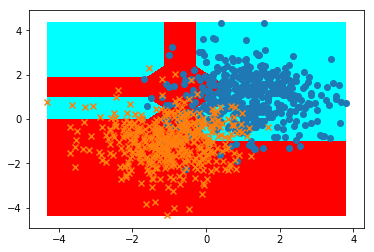

In [26]:
ut.plot_frontiere(F,foret,10)
ut.plot2DSet(F) 

### Evaluation par la méthode "Out Of Bags"

<font color="RED" size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue en cours. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.

Pour cela, écrire la classe <code>ClassifierBaggingTreeOOB</code> qui étend la classe d'un classifieur bagging pour prendre en compte la spécificité de l'approche OOB.
Ainsi, à partir de $\mathcal{X}$, l'ensemble des données d'apprentissage, chaque arbre $A_i$ de la forêt est associé à 2 sous-ensembles de $\mathcal{X}$: 
- $\mathcal{X}_i$: l'échantillon bootstrap qui sert à construire l'arbre $A_i$
- $\mathcal{T}_i$: l'ensemble des exemples OOB associés à l'arbre $A_i$

Le calcul du taux de bonne classification s'effectuera comme suit:
- soit $t_i$ le taux de bonne classification de $A_i$ pour l'ensemble OOB $\mathcal{T}_i$
- le taux de global de bonne classification de la forêt d'arbres $A_1$,..., $A_B$ est donné par $\frac{1}{B}\sum_{i=1}^{B} t_i$


In [27]:
class ClassifierBaggingTreeOOB(ClassifierBaggingTree):
    
    def __init__(self, nbB, percent, epsilon, remise):
        ClassifierBaggingTree.__init__(self, nbB, percent, epsilon,remise)
        self.list_ad = []

            
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        sumVote = 0
        
        for ad,ti in self.list_ad:
            res = ad.predict(x)
            sumVote+=res
        if sumVote < 0 :
            return -1
        else: return 1
            
    def train(self, data_train):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        for i in range(self.nbB):
            m = int(data_train.size()*self.percent)
            
            xi = echantillonLS(data_train,m, self.remise)
            
            ti = diff(data_train,xi)
            
            ad = ArbreDecision(self.epsilon)
            ad.train(xi)
            #print("test :: ",data_train.size())
            
            self.list_ad.append((ad,ti))  
            
    def accuracy(self, data_test):
        """ Permet de calculer la qualité du système 
        """
        B = len(self.list_ad)
        somme = 0
        for ad,Ti in self.list_ad:
            ti = ad.accuracy(Ti) 
            somme += ti
       
        return ((1/B)*1.0)*somme

exemple: 0  vraie classe =  [1] - classe trouvee =  1
exemple: 1  vraie classe =  [1] - classe trouvee =  1
exemple: 2  vraie classe =  [1] - classe trouvee =  1
exemple: 3  vraie classe =  [1] - classe trouvee =  1
exemple: 4  vraie classe =  [1] - classe trouvee =  1
exemple: 5  vraie classe =  [1] - classe trouvee =  1
exemple: 6  vraie classe =  [1] - classe trouvee =  1
exemple: 7  vraie classe =  [1] - classe trouvee =  1
exemple: 8  vraie classe =  [1] - classe trouvee =  1
exemple: 9  vraie classe =  [1] - classe trouvee =  1
exemple: 10  vraie classe =  [-1] - classe trouvee =  -1
exemple: 11  vraie classe =  [-1] - classe trouvee =  -1
exemple: 12  vraie classe =  [-1] - classe trouvee =  -1
exemple: 13  vraie classe =  [-1] - classe trouvee =  -1
exemple: 14  vraie classe =  [-1] - classe trouvee =  -1
exemple: 15  vraie classe =  [-1] - classe trouvee =  1
exemple: 16  vraie classe =  [-1] - classe trouvee =  -1
exemple: 17  vraie classe =  [-1] - classe trouvee =  -1
exemp

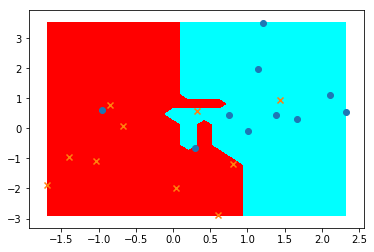

In [28]:
foret = ClassifierBaggingTreeOOB(10,1,0.0,True)
foret.train(set_exemples)
for i in range(set_exemples.size()):
    print("exemple:",i," vraie classe = ", set_exemples.getY(i), "- classe trouvee = ", foret.predict(set_exemples.getX(i)))
    
ut.plot_frontiere(set_exemples,foret,20)
ut.plot2DSet(set_exemples) 

print("\naccuracy totale:",foret.accuracy(set_exemples))

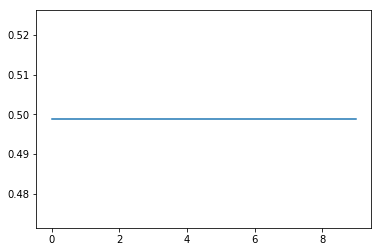

In [45]:
#### TEST SUR SEULEMENT 10 ARBRES ####

ite = []
evol_accuracy_train  = []
foret = ClassifierBaggingTreeOOB(10,1,0.0,True)
foret.train(set_exemples)
for i in range (len(foret.list_ad)):
    evol_accuracy_train.append(foret.accuracy(set_exemples))
    ite.append(i)
    
plt.plot(ite, evol_accuracy_train)
plt.show()

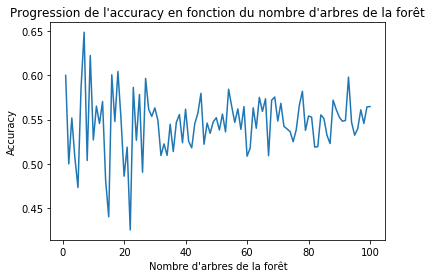

In [107]:
#### TEST EN AUGMENTANT LE NB D'ARBRES ####

ite = []
evol_accuracy_train  = []

NB = 100

x = 1
while x <= NB :
    foret = ClassifierBaggingTreeOOB(x,1,0.0,True)
    foret.train(set_exemples)
    evol_accuracy_train.append(foret.accuracy(set_exemples))
    ite.append(x)
    x += 1

plt.plot(ite, evol_accuracy_train)
plt.xlabel("Nombre d'arbres de la forêt")
plt.ylabel("Accuracy")
plt.title("Progression de l'accuracy en fonction du nombre d'arbres de la forêt")
plt.show()

## Etape 3: Random forests

<font color="RED" size="+1">**[Q]**</font> Ecrire et tester la classe <code>ClassifierRandomForest</code> qui implémente l'algorithme des random forests vu en cours.

Pour cela, vous devrez:
- définir une méthode <code>construit_AD_aleatoire(LSet,epsilon,nbatt)</code> qui utilise $nbatt$ attributs choisis aléatoirement à chaque niveau de la construction de l'arbre
- définir une nouvelle classe <code>ArbreDecisionAleatoire</code> qui étend la classe <code>ArbreDecision</code> en surchargeant la méthode <code>train</code>. Le constructeur d'un tel arbre prendra en argument le nombre d'attributs à utiliser lors de la construction de l'arbre.

In [31]:
def divise(LSet,att,seuil):
    """ LSet: LabeledSet
        att : numéro d'attribut
        seuil : valeur de seuil
        rend le tuple contenant les 2 sous-LabeledSet obtenus par la
        division de LSet selon le seuil sur l'attribut att
    """
    #Etape 1: ordonner de façon croissante les valeurs de  AXAX ;
    label_inf = ls.LabeledSet(LSet.getInputDimension())
    label_sup = ls.LabeledSet(LSet.getInputDimension())

    for i in range(0,LSet.size()):
        if (LSet.getX(i)[att] < seuil):
            label_inf.addExample(LSet.getX(i), LSet.getY(i))
            
        else : label_sup.addExample(LSet.getX(i), LSet.getY(i))
    
    ### PERMET DE NE PAS AVOIR D'ENSEMBLE VIDE ###
    if label_inf.size() == 0:
        label_inf.size = 1
        
    if label_sup.size()== 0:
        label_sup.size = 1
        
    
    return label_inf,label_sup

In [32]:
def construit_AD_aleatoire(LSet,epsilon,nbatt):
    """ LSet : LabeledSet
        epsilon : seuil d'entropie pour le critère d'arrêt 
    """
   
    arbre = ArbreBinaire()
    entro = entropie(LSet)
   
    if entro <= epsilon :
        #construction
        classe = classe_majoritaire(LSet)
        arbre.ajoute_feuille(classe)
        
    else : 
        l_seuil = []
        l_entropie = []
        
        vect = [ i for i in range(LSet.input_dimension)]
        liste_attr = tirage(vect, nbatt, True)
            
        tmp = []
        for attr in range(LSet.input_dimension):
        #for attr in liste_attr:
            seuil, entro = discretise(LSet, attr)
            l_seuil.append(seuil), l_entropie.append(entro)
            tmp.append(attr)
        
        
            
        att_min = np.argmin(np.array(l_entropie))
        seuil_min = l_seuil[att_min]
        
        inf, sup = divise(LSet,att_min,seuil_min)
        # DIVISION PAR ZERO CAR UN DES DEUX ENSEMBLES EST VIDE
        ab_inf = construit_AD_aleatoire(inf,epsilon,nbatt)

        ab_sup = construit_AD_aleatoire(sup,epsilon,nbatt)
        
        arbre.ajoute_fils(ab_inf,ab_sup,att_min,seuil_min)
    
    return arbre

In [93]:
class ArbreDecisionAleatoire(ArbreDecision):
    # Constructeur
    def __init__(self,epsilon, nbatt):
        # valeur seuil d'entropie pour arrêter la construction
        ArbreDecision.__init__(self, epsilon)
        self.nbatt = nbatt
        
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        classe = self.racine.classifie(x)
        if (classe == 1):
            return(1)
        else:
            return(-1)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        
        self.racine = construit_AD_aleatoire(set,self.epsilon, self.nbatt)

    # Permet d'afficher l'arbre
    def plot(self):
        gtree = gv.Digraph(format='png')
        return self.racine.to_graph(gtree)
        

In [34]:
class ClassifierRandomForest(cl.Classifier):
    
    def __init__(self, nbB, percent, epsilon, remise, nbatt):
        self.list_ad = []
        self.nbB = nbB
        self.percent = percent
        self.remise = remise
        self.epsilon = epsilon
        self.nbatt = nbatt
        
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        sumVote = 0

        for ad in self.list_ad:
            res = ad.predict(x)
            sumVote+=res
        if sumVote < 0 :
            return -1
        else: return 1
            
    def train(self, data_train):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        for i in range(self.nbB):
            m =int(data_train.size()*self.percent)

            ls = echantillonLS(data_train,int(data_train.size()*self.percent), self.remise)
            ad = ArbreDecisionAleatoire(self.epsilon, self.nbatt)
            
            ad.train(ls)
            self.list_ad.append(ad)    
            
    def accuracy(self, data_test):
        """ Permet de calculer la qualité du système 
        """
        cpt = 0
        for i in range(data_test.size()):
            res = self.predict(data_test.getX(i))
            if (res * data_test.getY(i)) > 0 : 
               cpt += 1 
            
        return cpt/data_test.size()*1.0

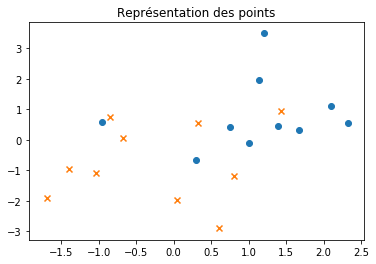

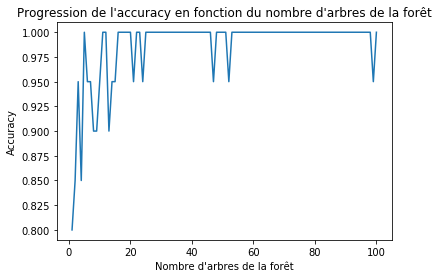

In [103]:
#### TEST EN AUGMENTANT LE NB D'ARBRES ####

ite = []
evol_accuracy_train  = []

NB = 100
x = 1
while x <= NB :
    foret = ClassifierRandomForest(x,1,0.0,True,2)
    foret.train(set_exemples)
    evol_accuracy_train.append(foret.accuracy(set_exemples))
    ite.append(x)
    x += 1
    
plt.title("Représentation des points")
ut.plot2DSet(set_exemples)
plt.show()
    
    
plt.plot(ite, evol_accuracy_train)
plt.xlabel("Nombre d'arbres de la forêt")
plt.ylabel("Accuracy")
plt.title("Progression de l'accuracy en fonction du nombre d'arbres de la forêt")
plt.show()

On remarque l on a une accuracy constante de 100% assez stabilisée à partir de 40 arbres.

## Etape 4: expérimentation

<font color="RED" size="+1">**[Q]**</font> Comparer le bagging d'arbres et les random forests sur d'autres bases d'apprentissage (réelles ou générées aléatoirement). Construire la courbe donnant le taux de prédiction pour une forêt d'arbres variant de 1 à 100 arbres (cela peut prendre du temps, tester sur un nombre réduit d'arbres dans un premier temps).

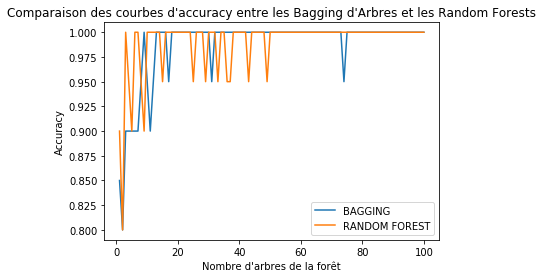

In [68]:
#### TEST EN AUGMENTANT LE NB D'ARBRES ####

ite = []
evol_accuracy_train_BAG  = []

evol_accuracy_train_FOREST  = []

NB = 100
x = 1
while x <= NB :
    bagging = ClassifierBaggingTree(x,1,0.0,True)
    bagging.train(set_exemples)
    
    foret = ClassifierRandomForest(x,1,0.0,True,2)
    foret.train(set_exemples)
    
    
    evol_accuracy_train_FOREST.append(foret.accuracy(set_exemples))
    evol_accuracy_train_BAG.append(bagging.accuracy(set_exemples))
    
    ite.append(x)
    x += 1

plt.plot(ite, evol_accuracy_train_BAG, label="BAGGING")
plt.plot(ite, evol_accuracy_train_FOREST, label="RANDOM FOREST")
plt.legend()
plt.xlabel("Nombre d'arbres de la forêt")
plt.ylabel("Accuracy")
plt.title("Comparaison des courbes d'accuracy entre les Bagging d'Arbres et les Random Forests")
plt.show()


On remarque que pour cet ensemble de LabeledSet, le résultat est assez similaire entre les deux méthodes, nous allons donc tester cela sur d'autres ensembles tirés de dataset réels.

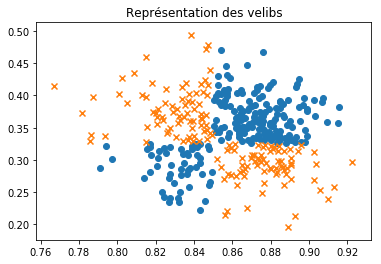

In [71]:
#### RECUPERATION DATASET VELIBS

data = pd.read_csv('velib-disponibilite-en-temps-reel.csv', delimiter= ';')

res = data['geo'] # On récupère les coordonnées géographiques des vélibs (str)
classes = data['Achat possible en station (CB)']
dataSet = ls.LabeledSet(2) # on crée un dataSet

# On essaye d'espacer les données
COEF_X = 48
COEF_Y =  2
MILIEU_X = 48.850 - COEF_X
MILIEU_Y = 2.325 - COEF_Y

epsilon = 0.7

for i in range(0,len(res)-1):
    if (np.random.uniform(0,1)>epsilon):
        tmp_list = res[i].split(",")  # on split car les coordonnées sont séparées par un point virgule
        x = float(tmp_list[0]) - COEF_X
        y = float(tmp_list[1])- COEF_Y

        # Effectue une séparation des données à la manière d'un XOR
        if (x < MILIEU_X and y > MILIEU_Y) or (x > MILIEU_X and y< MILIEU_Y): 
            classe = -1
        else :
            classe = 1
        dataSet.addExample([x, y], classe) # On remplit notre dataSet
    
plt.title("Représentation des velibs")
ut.plot2DSet(dataSet)
plt.show()

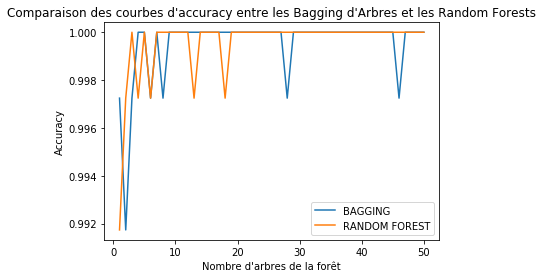

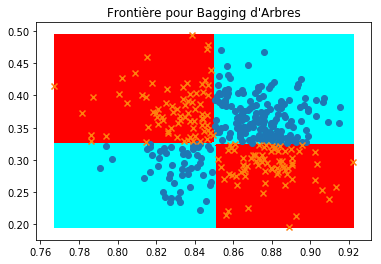

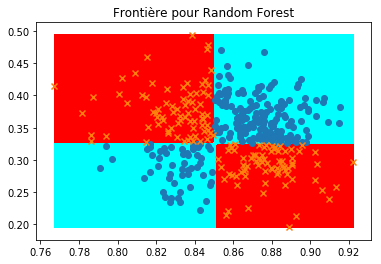

In [89]:
#### TEST EN AUGMENTANT LE NB D'ARBRES ####

ite = []
evol_accuracy_train_BAG  = []

evol_accuracy_train_FOREST  = []

NB = 50
x = 1
while x <= NB :
    bagging = ClassifierBaggingTree(x,1,0.0,True)
    bagging.train(dataSet)
    
    foret = ClassifierRandomForest(x,1,0.0,True,2)
    foret.train(dataSet)
    
    
    evol_accuracy_train_FOREST.append(foret.accuracy(dataSet))
    evol_accuracy_train_BAG.append(bagging.accuracy(dataSet))
    
    ite.append(x)
    x += 1

plt.plot(ite, evol_accuracy_train_BAG, label="BAGGING")
plt.plot(ite, evol_accuracy_train_FOREST, label="RANDOM FOREST")
plt.legend()
plt.xlabel("Nombre d'arbres de la forêt")
plt.ylabel("Accuracy")
plt.title("Comparaison des courbes d'accuracy entre les Bagging d'Arbres et les Random Forests")
plt.show()


ut.plot_frontiere(dataSet,bagging,500)
ut.plot2DSet(dataSet)
plt.title("Frontière pour Bagging d'Arbres")
plt.show()


ut.plot_frontiere(dataSet,foret,500)
ut.plot2DSet(dataSet)
plt.title("Frontière pour Random Forest")
plt.show()


On remarque que la méthode Random Forest donne une meilleure accuracy que la méthode Bagging, en effet à partir de 20 arbres, Random Forest a une accuracy de 100% et est stabilisé contrairement à la méthode des Bagging D'Arbres où l'on observe des petites baisses d'accuracy. 

In [104]:
X = newSet_eq(1,1000)

Y_1 = echantillonLS_classe(X,50,False,1)
Y_2 = echantillonLS_classe(X,50,False,-1)
print("Classe + :: ",Y_1.size())
X = diff(X,Y_1)
print("Classe - :: ",Y_2.size())
F = diff(X,Y_2)
E = concat(Y_1,Y_2)
print("Ensemble E :: ",E.size())
print("Ensemble restant F :: ",X.size())

Classe + ::  50
Classe - ::  50
Ensemble E ::  100
Ensemble restant F ::  950


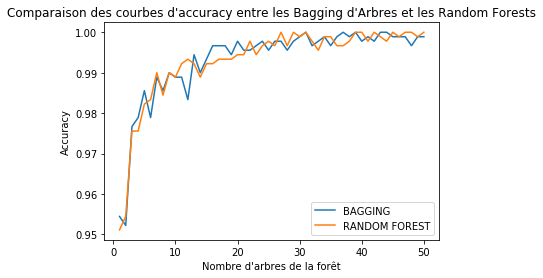

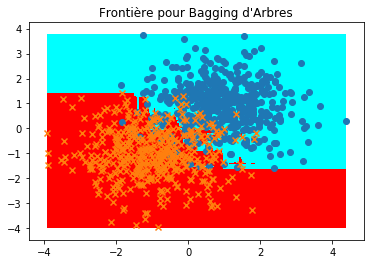

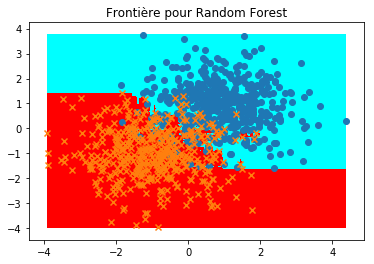

In [106]:
#### TEST EN AUGMENTANT LE NB D'ARBRES ####

ite = []
evol_accuracy_train_BAG  = []

evol_accuracy_train_FOREST  = []

NB = 50
x = 1
while x <= NB :
    bagging = ClassifierBaggingTree(x,1,0.0,True)
    bagging.train(F)
    
    foret = ClassifierRandomForest(x,1,0.0,True,2)
    foret.train(F)
    
    
    evol_accuracy_train_FOREST.append(foret.accuracy(F))
    evol_accuracy_train_BAG.append(bagging.accuracy(F))
    
    ite.append(x)
    x += 1

plt.plot(ite, evol_accuracy_train_BAG, label="BAGGING")
plt.plot(ite, evol_accuracy_train_FOREST, label="RANDOM FOREST")
plt.legend()
plt.xlabel("Nombre d'arbres de la forêt")
plt.ylabel("Accuracy")
plt.title("Comparaison des courbes d'accuracy entre les Bagging d'Arbres et les Random Forests")
plt.show()


ut.plot_frontiere(F,bagging,500)
ut.plot2DSet(F)
plt.title("Frontière pour Bagging d'Arbres")
plt.show()


ut.plot_frontiere(F,foret,500)
ut.plot2DSet(F)
plt.title("Frontière pour Random Forest")
plt.show()


Dans un premier temps on remarque que l'accuracy des Bagging d'Arbres OOB et de Random Forest est située entre 0.99 et 1 mais tend bien plus vers 1, contrairement à l'accuracy des Bagging non OOB qui était de 0.94 pour le même dataset, les solutions OOB et Random Forest sont donc bien meilleures.
Egalement, on remarque que les deux solutions OOB et Random Forest ont à peu près la même accuracy, mais encore une fois, grâce aux courbes on remarque que la méthode Random Forest l'emporte légèrement

## Exercices à faire chez vous (sur papier)

Pour vous entraîner sans machine... *(exercice de l'examen 2017)*

Soit $V=\{v_{1}, v_{2},..., v_{n}\}$ un ensemble de $n$ valeurs réelles ordonnées,
  telles que $v_1 \geq v_2 \geq \ldots \geq v_{n}$.. On note $\bar{v}$ la valeur moyenne de $V$. La variance de $V$, $var(V)$ est définie par:
$var(V) = \frac{1}{n} \sum_{i=1}^{n} (v_{i} - \bar{v})^2$. 

Et soit $W=\{w_{1}, w_{2},..., w_{n}\}$ tel que,pour tout $i=1,...,n$.


** [Q] ** Donner l'expression de $\bar{v}$ en fonction des valeurs de $V$.

** [Q] **  Montrer que $var(aV+b) = a^2 var(V)$.

** [Q] ** Donner l'expression de $V\cdot W$ (le produit scalaire) en fonction des coordonnées
   de $V$ et de $W$.
   
** [Q] ** Comment doit-on définir $W$ si on souhaite que $V\cdot W = \bar{v}$ ?


** [Q] ** Comment doit-on définir $W$ si on souhaite que
   $V\cdot W = \displaystyle\max_{i=1,...n} v_i$ ? Même question si on souhaite que
   $V\cdot W = \displaystyle\min_{i=1,...n} v_i$ ?

** [Q] ** Soit un entier $k$ tel que $0<k\leq n$. Proposer une définition de $W$ qui, par le
   calcul du produit scalaire, permet de ne tenir compte, de façon équitable, que des $k$
   valeurs les plus élevées de $V$.

